# MNIST
#### A set of 70,000 small images of digits written by highschool students and employees of the US Census Bureau. Each image is labeled with the digit it represents. 

In [1]:
#Setup


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
#fetching the MNIST dataset

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

#### Dictionary structure: 
1. DESCR key describing the dataset
2. data key containing an array with one row per instance and one column per feature
3. target key cotaining an array with the labels 

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Saving figure some_digit_plot


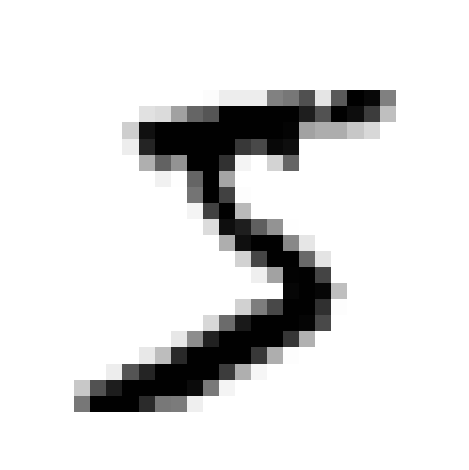

In [5]:
#70000 images with 784 features (28x28 pixels each feature represnets 
#pixels intensity from 0(white) to 255(black))
#Lets look at one

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
#note that the label below is a string but we will 
# cast as an integer to make things easier for the ML model

y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
y[0]

5

In [9]:
# always create a training and test set and put aside before inspecting data closely
#already done for us

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [10]:
#lets make a 5-dettector: a binary classifier:
#capable of distinguishing between two classes: 5 and not 5
#lets create the target vectors

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


In [11]:
#now lets train a model: Stoachastic Gradient Descent (SGD) classifier
#handles very large datasets efficiently 
#deals with trainig instaces one at a time (well suited for online learning)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
#now lets detect some images of 5

sgd_clf.predict([some_digit])

array([ True])

# Performance Measures
### Measuring accuracy using cross-validation

In [13]:
# custom cross-validation
#equivilent to cross_val_score() scikit-learn function

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))



0.9669
0.91625
0.96785


The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. 
Each iteration: clone of classifier created, trains on training folds, makes predictions, counts correct predictions, outputs ratio of correct predictions

In [14]:
#using cross_val_score()

from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
#don't get too excited: 
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#notice that 10% of the images are 5s
#if you always guess an image is 5, you will be correct 90% of the time


array([0.91125, 0.90855, 0.90915])

ACCURACY IS NOT THE PERFERRED PERFORMANCE MEASURE FOR CLASSIFIERS

### Confusion Matrix
Count the number of times instnaces of class A are classified as class B. 
Ex: to know number of times the classifier confused images 5 with 3, you look in the fifth row and the thrid column of confusion matrix. 

1. Make a set of predictions
2. Create confusion matrix

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row is an actual class, each column is a predicted class
First row is non-5 images (true-negatives): 53892 correctly classified as non-5s, remaining 687 wrongly classified as 5s (false-positives)

### Precision and Recall


In [18]:
# calculatiing usingn scikit-learn

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
#manual calculation
cm = confusion_matrix(y_train_5, y_train_pred)

cm[1,1] / (cm[0,1] + cm[1,1])

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
#manual calculation
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

F_1 mean, or harrmonic mean of precision and recall, gives weight to lower values so the classifier will only get a high F_1 if both recall and precision are high

In [22]:
#computing F_1 score

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
#calculatinng manually 

cm[1,1] / (cm[1,1] + (cm[1,0] + cm[0,1]) / 2)

0.7325171197343847

Warning: F_1 favors classifiers with similar precision and recall 
INCREASING PRECISION REDUCES RECALL, AND INCREASING RECALL REDUCES PRECISION: PRECISION/RECALL TRADEOFF 



In [24]:
#messing with the decision_function() method and using different thresholds
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
#raisinng threshold decreases recall 
#how to deciide which threshold to use? 

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method="decision_function")

In [28]:
#with these scores, we use precision_recall_curve() function to compute precisionn adn recall for all possible threshlds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


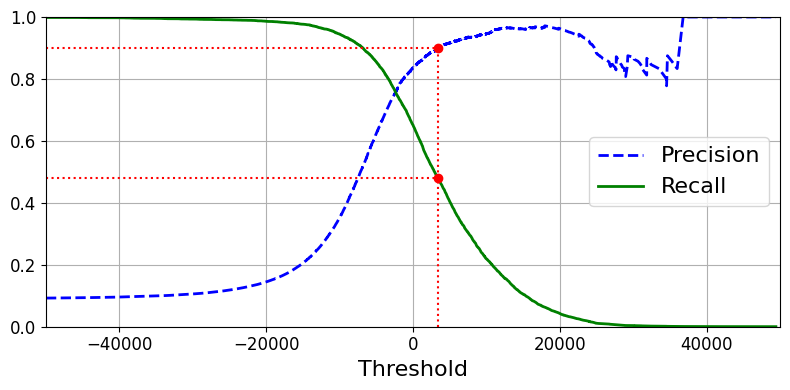

In [29]:
#plotting
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()


Sometimes, precision can go down as the threshold increases because of number of instances considered (ie. 4/5 to 3/4). 
Recall can only go down


In [30]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


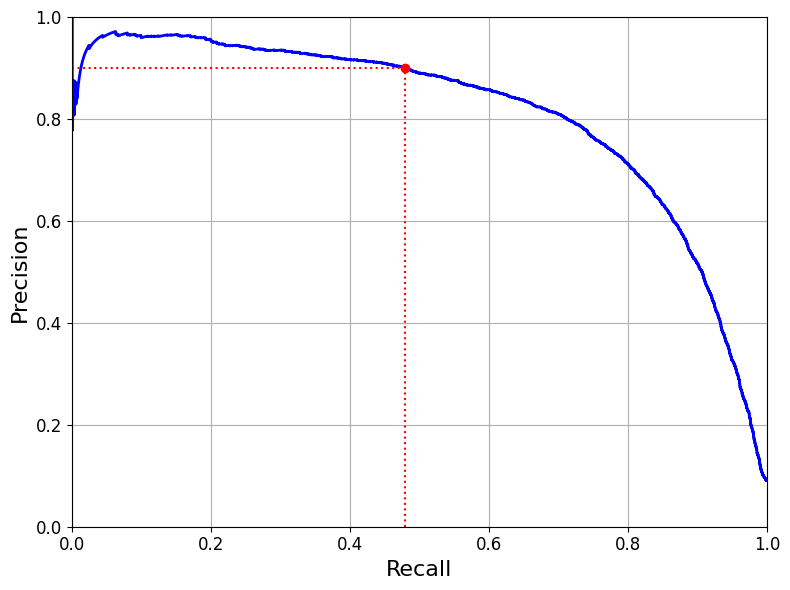

In [31]:
#plotting precision against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [32]:
# precision starts to fall sharply after 80% recall
#lets search for lowest threshold that gives you at least 90% precision
#np.argmax gives you first iindex of maximum value (first true value)

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [33]:
threshold_90_precision

3370.0194991439557

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

"Let's reach 99% precision!"
"But at what recall?"

### ROC Curve
Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiiers
Plots true positive rate (recall) against false positive rate(FPR)
Plots sensitivity (recall) versus specificity. 


In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


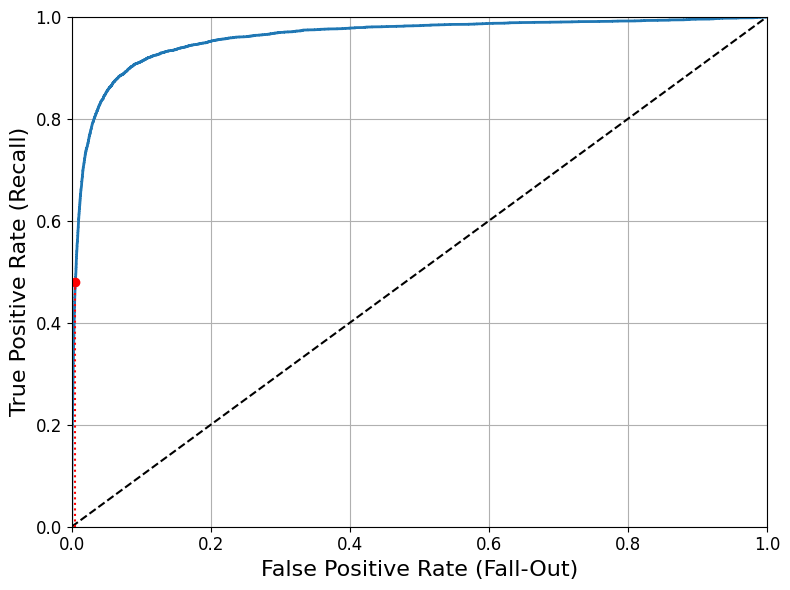

In [38]:
#plottiing
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [39]:
#higher recall (TPR), the more false positives (FPR) the classifier produces
#a good classifier stays as far away from the dotted line as possible
#a perfect classifier will have area under curve equal to 1
#a purely random classifier will have AUC of 0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

 YOU SHOULD PREFER PR CURVE WHENEVER TTHTE POSITIVE CLASS IS RARE OR WHEN YOU CARE MORE ABOUT FALSE POSITIVES THAN FALSE NEGATIVES
 OTHERISE USE ROC CURVE

In [40]:
#now lets train a RandomForestClassifier and compare its ROC curve and ROC AUC score
#has predict proba method instead of decision_function
#a row per instance and a column per class

from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

In [41]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


Saving figure roc_curve_comparison_plot


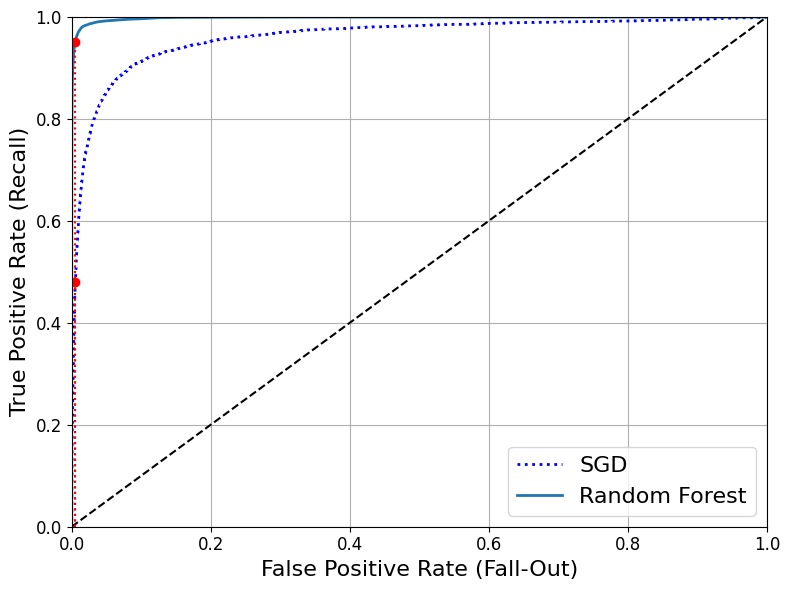

In [42]:
#plotting
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [43]:
#RFC looks much better, its farther away from dotted line
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [44]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [45]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification
Multiclass classifiers (aka multinomial classifiers) can distinguish between more than two classes

1. OvR Strategy (one-versus-rest): Train ten binary classifiers, one for each digit (0-detector, 1-detector, etc.)
    a. prefered for most binary classification algorithms unless they struggle to scale
2. OvO Strategy (one-versus-one): Trainn a binary classifier for every pair of digits (between 0s and 1s, 0s and 2s, 1s and 2s, etc)
    a. if there are N classes, you need to train N x (N-1)/2 classifiers, which can end up to be a lot. 
    

In [46]:
#lets try a Support Vector Machine Classifier
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

#trained 45 classifiers (OvO), got their decision scores, selected class that won the most duels

array([5], dtype=uint8)

In [47]:
#lets see the decision_function() method
#notice it returns 10 scores per isntance 
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [48]:
#highest score is the one corresponding to class 5
np.argmax(some_digit_scores)

5

In [49]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
#forcing Scikit-learn to use OvR or OvO: OneVsOneClassifer or OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
#trainign an SGDClassifier is just as easy 
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [52]:
#didn't have to run OvO or OvR because SGD classifiers can directly do it
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
#lets check accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [54]:
#scaling the input increases accuracy above 89%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')


array([0.8983, 0.891 , 0.9018])

# Error Analysis 
#### Assuming you have found a promising model and want to find ways to improve it
1. Do this by analyzing the errors it makes

In [58]:
#first, lets look at the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [65]:
!pip3 install --upgrade scikit-learn
print(sklearn.__version__)


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
1.2.2


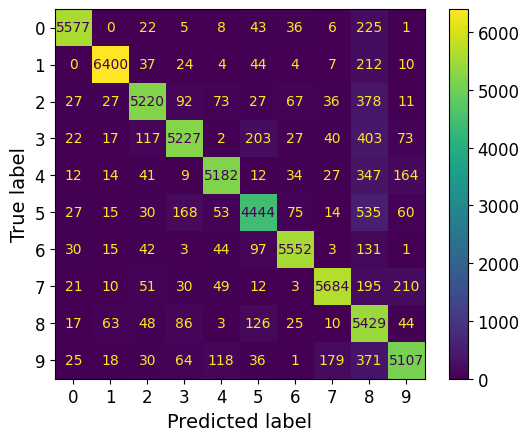

In [67]:
#lets look at an image representation to get a better perspective 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_mx = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx)
disp.plot()
plt.show()

In [68]:
#matrix looks good since most images are on the main diagonal. 
#it is common that 3s and 5s often get confused both ways
#also theres a lot of misclassed 8s

Misclassed solutions
1. Gather more training data for digits that look like 8s but arent, so the classifier could learn to distinguish better
2. Engineer new features that would help the classifier--writing an algorithm to counnt the number of closed loops
3. Preprocess the images (Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, to stand out more. 

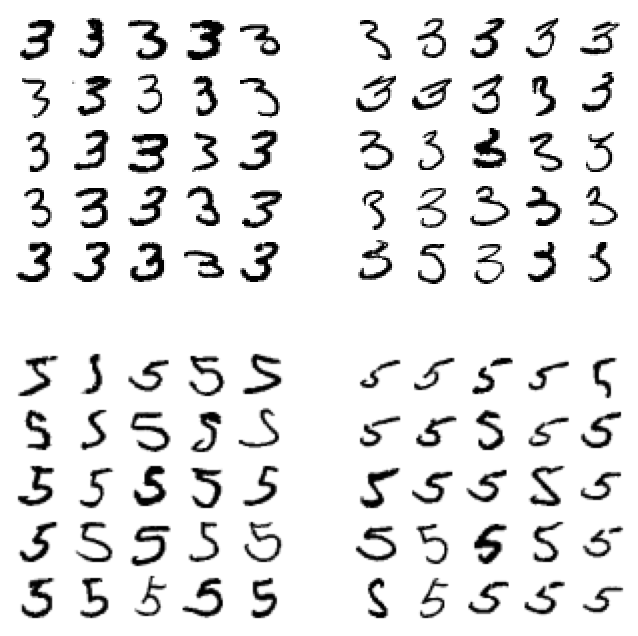

In [77]:
#analyzing individual errors. (3s and 5s)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

1. Classifier gets wrong: bottom-left and top-right
Why? 
We used SGD Classifier, wwhich is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image, it sums up weighted pixel intensities to get a scoroe for each class. 3s and 5s differ by a few pixels which makes sense. 
1. Solution: preprocess images to ensure they are well centered and not too rotated. 

# Multilabel Classification
##### Multilabel Classification System: one that outputs multiple binary tags

In [72]:
#example

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] #label whether number is large or odd 

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [74]:
#computing the average F1 score across all labels
#assumes all labels are equally important 
#to give weighted, set average to weighted
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# Multioutput Classification
#### A generalization of multilabel classification where each label can be a multiclass (have more than two possible values)
1. We will build a system that can remove noise from images

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


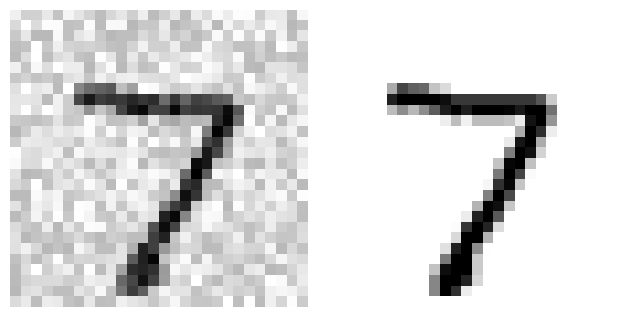

In [79]:
#lets look at the test set
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

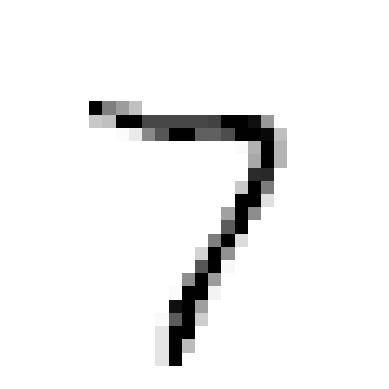

In [80]:
#now lets remove it
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)